# TotalJobs UK Data Engineer Job Analysis

# 📥 Step 1: Scrape and Load Data

In [8]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [6]:
skill_counts

1

In [11]:
import seaborn as sns

In [9]:
data = [0.25, 0.5, 0.75, 1.0]
series = pd.Series(data)
print(series)

0    0.25
1    0.50
2    0.75
3    1.00
dtype: float64


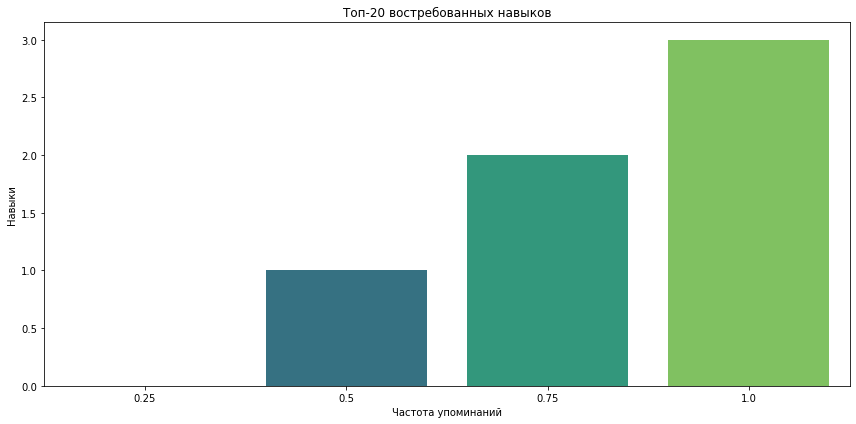

In [12]:
plt.figure(figsize=(12,6))
sns.barplot(x=series.values, y=series.index, palette='viridis')
plt.title("Топ-20 востребованных навыков")
plt.xlabel("Частота упоминаний")
plt.ylabel("Навыки")
plt.tight_layout()
plt.show()

# Scrape Data

In [ ]:
browser = webdriver.Chrome()
browser.get("https://www.totaljobs.com/")
time.sleep(5)
preferences = browser.find_element(By.ID, "ccmgt_explicit_preferences")
preferences.click()
reject = browser.find_element(By.ID, "ccmgt_preferences_reject")
reject.click()
input_tab = browser.find_element(By.CSS_SELECTOR, "input[data-at='searchbar-keyword-input']")
search_job_title = "Data Engineer"
input_tab.send_keys(search_job_title)
button_search = browser.find_element(By.XPATH, "//button[@aria-label='Search']")
button_search.click()
time.sleep(15)
job_data = []
next_button = True
while next_button:
    soup = BeautifulSoup(browser.page_source, 'lxml')
    jobs = soup.find_all('article', class_ = 'res-sfoyn7')
    for job in jobs:
        job_id = job.get('id')
        job_title = job.find('div', class_ = 'res-nehv70').get_text(strip=True)
        job_link = 'https://www.totaljobs.com' + job.find('a', class_ = 'res-1foik6i').get('href')
        try:
            job_details = job.find_all('span', class_='res-btchsq')
            company = job_details[0].get_text(strip=True) if len(job_details) > 0 else None
            location = job_details[1].get_text(strip=True) if len(job_details) > 1 else None
        except AttributeError:
            company, location = None, None
        job_data.append([job_id, job_title, company, location, salary, job_link, datetime.now().strftime("%Y-%m-%d %H:%M:%S")])
    print(f'I have already caught {len(job_data)} jobs')

    scroll_div = browser.find_element(By.CSS_SELECTOR, "div.res-vurnku[data-genesis-element='CARD_GROUP_CONTAINER']")
    for _ in range(14):
            ActionChains(browser).move_to_element(scroll_div).scroll_by_amount(1, 350).perform()
            sleep(randint(2,4))

    try:
        next_button = browser.find_element(By.CSS_SELECTOR, "a.res-1thqtcl[aria-label='Next']")
        next_button.click()
        time.sleep(15)
    except:
        print("The next button is disabled and cannot be clicked.")
        next_button = False
browser.quit()

df_header = ['job_id', 'job_title', 'company', 'location', 'job_link', 'loaded_at']
df = pd.DataFrame(job_data, columns = df_header)

title_keywords = {
    'Data Engineer': ['Data Engineer', 'Big Data Engineer', 'Junior Data Engineer', 'Graduate Data Engineer', 'Data Engineer Apprentice'],
    'Senior Data Engineer': ['Senior Data Engineer', 'Senior Big Data Engineer', 'Senior Database Engineer'],
    'Lead Data Engineer': ['Lead Data Engineer', 'Data Engineering Manager', 'Data Architect', 'Principal Data Engineer', 'Head of Data Engineering', 'Director of Data Engineering']
}
def extract_title_type(text, title_kw_dict):
    for label in ['Lead Data Engineer', 'Senior Data Engineer', 'Data Engineer']:  # prioritizing the order
        terms = title_kw_dict.get(label, [])
        for term in terms:
            if re.search(rf'\b{re.escape(term)}\b', text, re.IGNORECASE):
                return label
    return 'Not matched'

df['title'] = df['job_title'].apply(lambda x: extract_title_type(str(x), title_keywords))
indexdrop = df[df['title'] == "Not matched"].index
df.drop(indexdrop, inplace = True)
df.to_csv(r'C:\Users\Kirill\Desktop\de_totaljobs_df1st.csv')

df_unique = df[['job_id', 'job_link']].reset_index(drop=True)
add_data = []
for job_id, url in tqdm(zip(df['job_id'], df['job_link']), total = len(df), desc="Scraping"):
    application_form, work_type, published_at, job_content, latitude, longitude = (None,) * 6
    sleep(randint(5,10))
    try:
        browser.get(url)
        WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        soup = BeautifulSoup(browser.page_source, 'lxml')

        try:
            published_time = soup.select_one('meta[name="article:published_time"]')
            published_at = published_time.get('content') if published_time else None
        except AttributeError:
            published_at = None

        try:
            job_description = soup.find('div', class_='at-section-text-jobDescription-content')
            job_content = job_description.get_text(separator='\n', strip=True) if job_description else None
        except AttributeError:
            job_content = None

        try:
            script_geo = soup.find('script', type = 'application/ld+json')
            script_tag = json.loads(script_geo.string) if script_geo else None
            geo_data = script_tag.get('jobLocation', {}).get('geo', {}) if script_tag else None
            latitude = geo_data.get('latitude') if geo_data else None
            longitude = geo_data.get('longitude') if geo_data else None
        except AttributeError:
            latitude, longitude = None   

        add_data.append([job_id, published_at, job_content, latitude, longitude])
df2_header = ['job_id', 'application_form', 'work_type', 'published_at', 'job_content', 'latitude', 'longitude']
df2 = pd.DataFrame(add_data, columns = df2_header)

df_merge = df.merge(df2, left_on='job_id', right_on='job_id', how='right')
gdf = gpd.read_file('C:/Users/Kirill/Downloads/International_Territorial_Level_1_January_2021_UK_BUC_2022_-200740627039555061.geojson')
gdf_merge = gpd.GeoDataFrame(df_merge, geometry=gpd.points_from_xy(df_merge.longitude, df_merge.latitude), crs="EPSG:4326")
sdf = gpd.sjoin(gdf_merge, gdf[['ITL121NM', 'geometry']], how='left', predicate='within')
sdf.rename(columns={'ITL121NM': 'region'}, inplace=True)

In [ ]:
df = pd.read_csv("../data/de_totaljobs_test2.csv")

In [ ]:
impor

Inspect structure